In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
import os
import cv2
from PIL import Image
import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Rastgelelik kontrolü
np.random.seed(42)
tf.random.set_seed(42)


print(f" TensorFlow Versiyonu: {tf.__version__}")
print(f" GPU Kullanımı: {len(tf.config.list_physical_devices('GPU')) > 0}")

2025-09-26 16:49:53.738112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758905393.951307      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758905394.014485      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


 TensorFlow Versiyonu: 2.18.0
 GPU Kullanımı: True


Projede
* NumPy -> matematiksel işlemler ve diziler için
* Pandas -> CSV ve tablo verileri için
* Matplotlib & Seaborn -> grafik çizmek ve görselleştirme için
* sklearn.metrics -> başarı ölçmek için rapor ve confusion matrix üretmek için
* TensorFlow/Keras -> CNN modelini kurmak ve eğitmek için
* ImageDataGenerator -> görüntüleri okuma, ölçekleme ve çoğaltma için
* Callbacks -> erken durdurma, öğrenme hızını ayarlama, en iyi modeli kaydetme için
* Optimizers -> modelin öğrenmesini sağlamak için
* os -> dosya ve klasör yolları için
* cv2 -> OpenCV, hızlı görüntü işleme için
* PIL -> resimleri açıp dönüştürmek için
* warnings -> gereksiz uyarıları kapatmak için import ediliyor.


In [ ]:
# Veri seti yolları - farklı ortamlar için uyumlu
def find_dataset_path():
    """Veri seti yolunu otomatik bulur"""
    possible_paths = [
        '/kaggle/input/intel-image-classification/seg_train/seg_train',
        './data/seg_train/seg_train',
        '../intel-image-classification/seg_train/seg_train',
        './intel-image-classification/seg_train/seg_train'
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            base_path = path.replace('/seg_train/seg_train', '')
            return {
                'train': os.path.join(base_path, 'seg_train', 'seg_train'),
                'test': os.path.join(base_path, 'seg_test', 'seg_test'),
                'pred': os.path.join(base_path, 'seg_pred', 'seg_pred')
            }
    
    print(" Veri seti bulunamadı. Kaggle'da çalışıyorsanız 'Add Data' ile veri setini ekleyin.")
    return None

# Veri setini bul
data_paths = find_dataset_path()

# Sınıf bilgileri
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
num_classes = len(class_names)

print(f" Sınıflar: {class_names}")
print(f" Toplam Sınıf Sayısı: {num_classes}")

# Veri sayım fonksiyonu
def count_images_in_directory(directory):
    """Dizindeki görüntü sayısını ve dağılımını hesaplar"""
    if not os.path.exists(directory):
        return None, 0
        
    count_dict = {}
    total = 0
    
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path) 
                        if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            count_dict[class_name] = count
            total += count
    
    return count_dict, total

# Veri seti istatistikleri
if data_paths:
    train_counts, train_total = count_images_in_directory(data_paths['train'])
    test_counts, test_total = count_images_in_directory(data_paths['test'])
    
    print(f"\n EĞİTİM SETİ İSTATİSTİKLERİ:")
    for class_name, count in train_counts.items():
        print(f"   {class_name:<12}: {count:>6,} görüntü")
    print(f"   {'TOPLAM':<12}: {train_total:>6,} görüntü")
    
    print(f"\n TEST SETİ İSTATİSTİKLERİ:")
    for class_name, count in test_counts.items():
        print(f"   {class_name:<12}: {count:>6,} görüntü")
    print(f"   {'TOPLAM':<12}: {test_total:>6,} görüntü")
else:
    # Demo veriler (veri seti yokken)
    train_counts = {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 
                   'mountain': 2512, 'sea': 2274, 'street': 2382}
    test_counts = {'buildings': 437, 'forest': 474, 'glacier': 553, 
                  'mountain': 525, 'sea': 510, 'street': 481}
    train_total = sum(train_counts.values())
    test_total = sum(test_counts.values())
    print(" Demo istatistikler yüklendi (gerçek veri seti bulunamadı)")

 Sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
 Toplam Sınıf Sayısı: 6

 EĞİTİM SETİ İSTATİSTİKLERİ:
   mountain    :  2,512 görüntü
   street      :  2,382 görüntü
   buildings   :  2,191 görüntü
   sea         :  2,274 görüntü
   forest      :  2,271 görüntü
   glacier     :  2,404 görüntü
   TOPLAM      : 14,034 görüntü

 TEST SETİ İSTATİSTİKLERİ:
   mountain    :    525 görüntü
   street      :    501 görüntü
   buildings   :    437 görüntü
   sea         :    510 görüntü
   forest      :    474 görüntü
   glacier     :    553 görüntü
   TOPLAM      :  3,000 görüntü


Bu kod bloğu aslında üç ana iş yapıyor: veri setinin nerede olduğunu tanımlamak, sınıfları belirlemek ve her sınıfta kaç tane görüntü olduğunu saymak.  

İlk kısımda `train_dir`, `test_dir` ve `pred_dir` ile veri setinin klasör yollarını veriyoruz. Bu, bilgisayara “görseller şu klasörlerde” demek gibi. Eğer bu kısım olmazsa model hangi verileri okuyacağını bilmez ve çalışmaz.  

Sonra `class_names` listesiyle veri setindeki kategorileri tanımlıyoruz: **binalar, orman, buzullar, dağ, deniz ve sokak**. `num_classes` ile de toplam sınıf sayısını alıyoruz. Bu bilgi, modelin son katmanında kaç çıkış olması gerektiğini belirlemek için çok önemli. Örneğin 6 sınıf varsa, modelin çıktısı da 6 olmalı.  

Daha sonra `count_images_in_directory` fonksiyonu geliyor. Bu fonksiyon verilen klasördeki alt klasörleri geziyor, yani her sınıfı tek tek dolaşıyor. İçinde kaç tane görsel olduğunu sayıyor ve hem her sınıf için hem de toplamda kaç görsel olduğunu döndürüyor. Böylece veri setini daha iyi tanımış oluyoruz. Eğer bu sayım yapılmazsa elimizdeki verinin dengesini bilemeyiz. Mesela “orman” 2000 resimken “sokak” sadece 500 resimse, model ormana daha fazla alışır ve sokakta daha çok hata yapar. Bu tür dengesizlikleri fark edip **veri artırma (augmentation)** veya farklı yöntemlerle denge kurmamız gerekir.  

Son kısımda bu fonksiyon çağrılıyor ve elde edilen sayılar ekrana yazdırılıyor. Burada amaç sadece dosyaların doğru okunup okunmadığını görmek değil, aynı zamanda elimizde ne kadar veri olduğunu da netleştirmek. Çünkü model eğitimi için toplam görsel sayısı, batch ayarları ve epoch sayısı gibi parametrelerde önemli rol oynar.  

**Özetle:** Bu kod bloğu, veri setini bilgisayara tanıtıyor, kategorileri belirliyor ve içerideki görsel sayısını çıkararak bize veri hakkında temel bir “röntgen” çekiyor. Eğer bu adımlar yapılmazsa, model eğitimine başlamadan önce verinin durumu hakkında hiçbir fikrimiz olmaz, bu da yanlış ayarlar, dengesiz sınıflar veya eksik dosyalar yüzünden eğitim sürecinde sorunlara yol açabilir.  


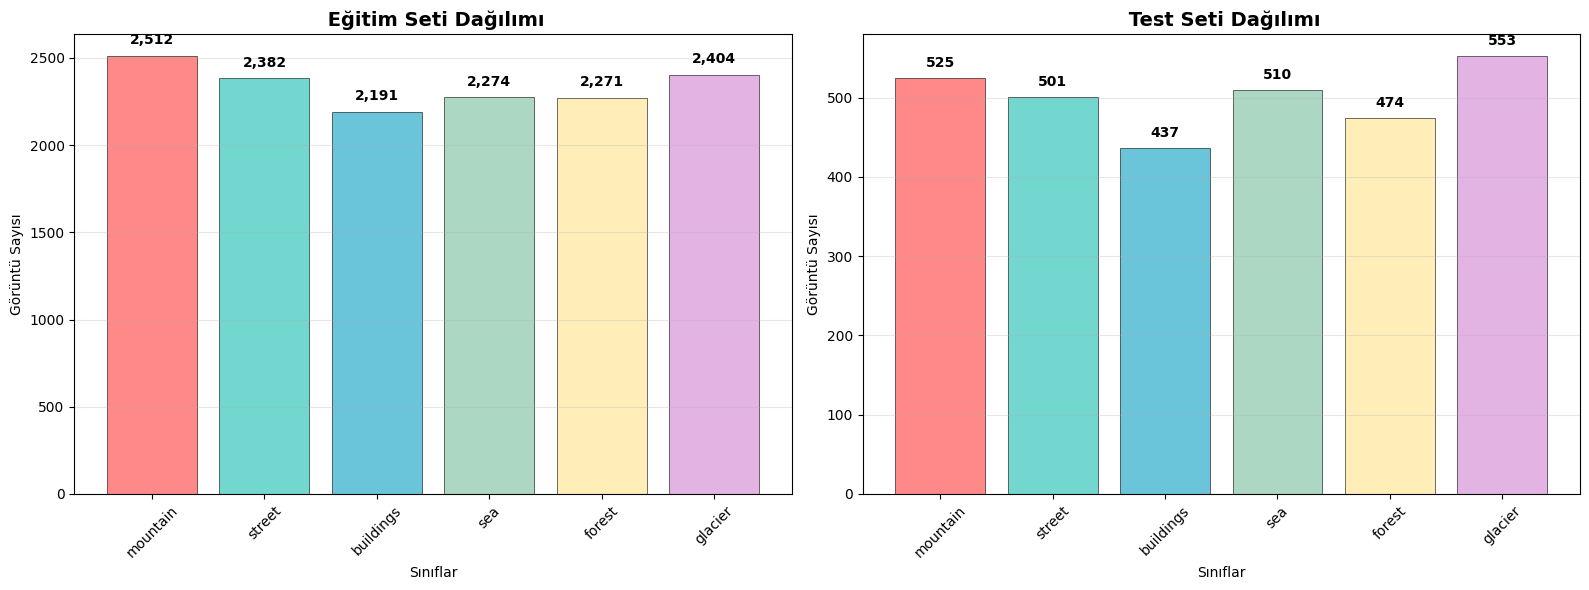

 Veri Seti Dengesi Analizi:
   Eğitim seti standart sapma: 105.5
   Test seti standart sapma: 36.9
    Eğitim seti dengeli


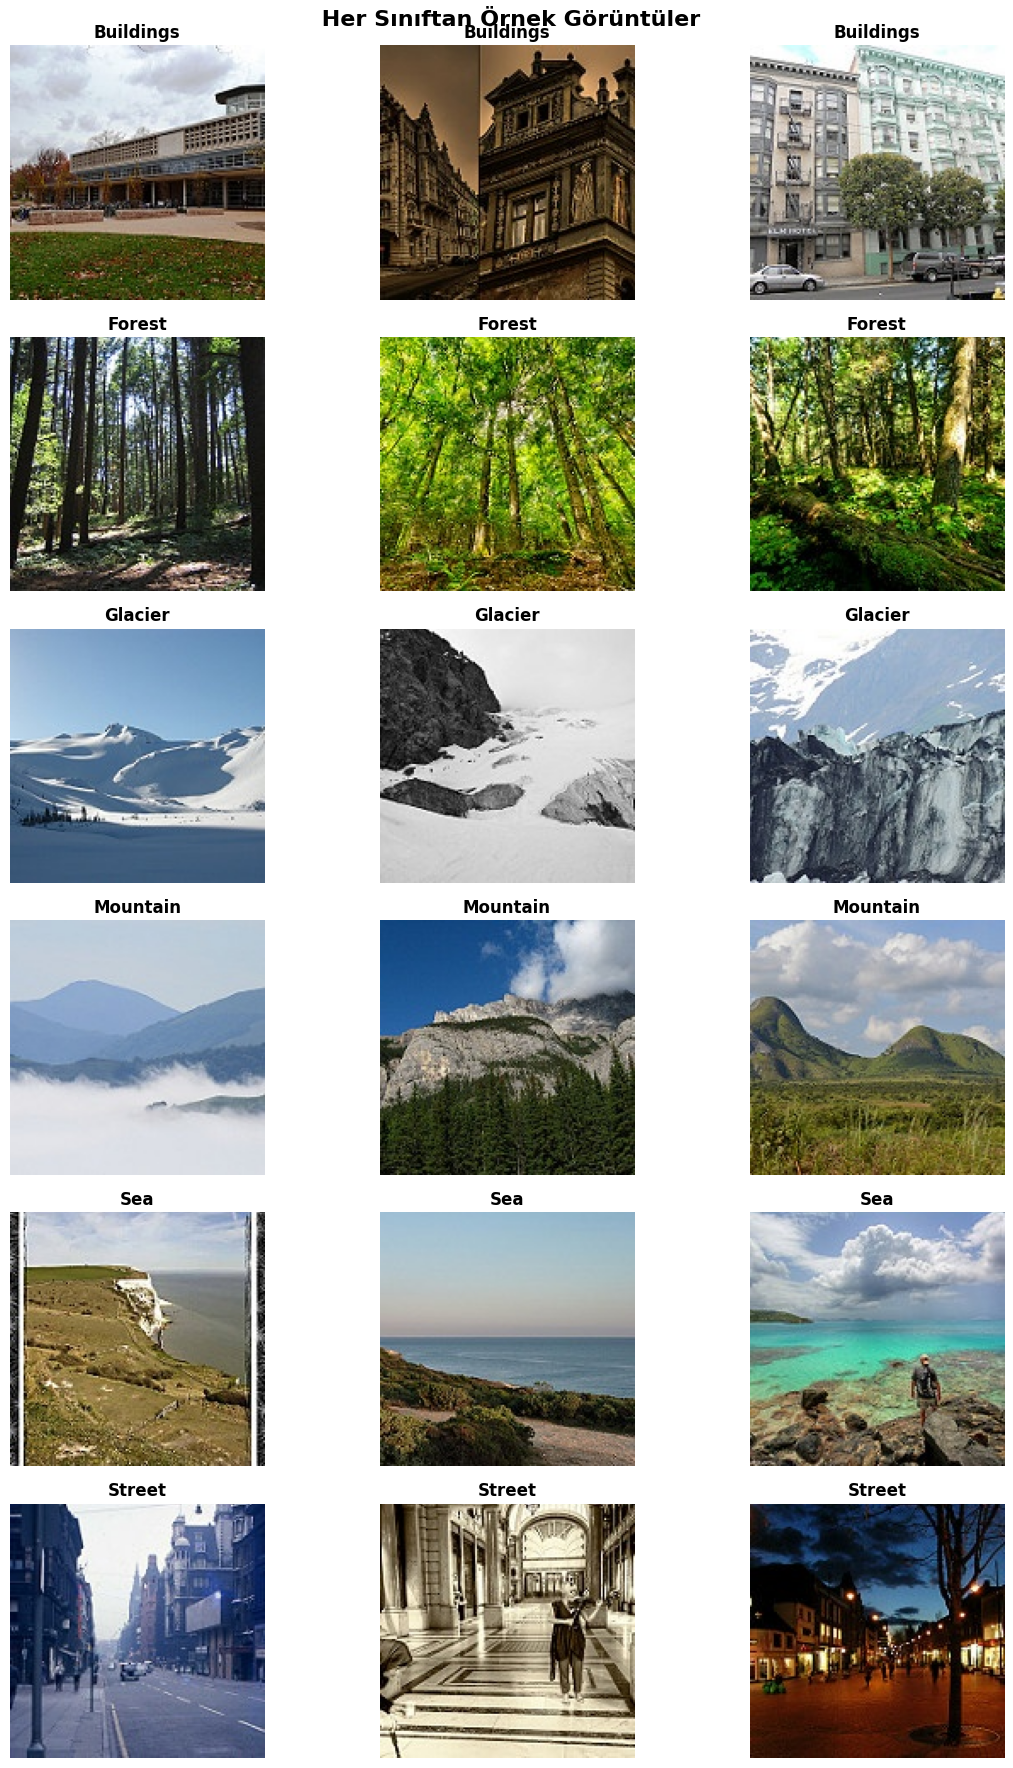

In [ ]:
# Sınıf dağılımını görselleştirme
def plot_class_distribution():
    """Veri seti dağılımını görselleştirir"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Eğitim seti
    train_df = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Count'])
    bars1 = axes[0].bar(train_df['Class'], train_df['Count'], 
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'],
                       alpha=0.8, edgecolor='black', linewidth=0.5)
    axes[0].set_title(' Eğitim Seti Dağılımı', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Sınıflar')
    axes[0].set_ylabel('Görüntü Sayısı')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Değerleri çubukların üzerine yazma
    for bar, count in zip(bars1, train_df['Count']):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                    f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    # Test seti
    test_df = pd.DataFrame(list(test_counts.items()), columns=['Class', 'Count'])
    bars2 = axes[1].bar(test_df['Class'], test_df['Count'], 
                       color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD'],
                       alpha=0.8, edgecolor='black', linewidth=0.5)
    axes[1].set_title(' Test Seti Dağılımı', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Sınıflar')
    axes[1].set_ylabel('Görüntü Sayısı')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Değerleri çubukların üzerine yazma
    for bar, count in zip(bars2, test_df['Count']):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                    f'{count:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Denge analizi
    train_std = np.std(list(train_counts.values()))
    test_std = np.std(list(test_counts.values()))
    
    print(f" Veri Seti Dengesi Analizi:")
    print(f"   Eğitim seti standart sapma: {train_std:.1f}")
    print(f"   Test seti standart sapma: {test_std:.1f}")
    
    if train_std < 200:
        print("    Eğitim seti dengeli")
    else:
        print("    Eğitim setinde dengesizlik var")

plot_class_distribution()

# Örnek görüntüleri gösterme
def display_sample_images():
    """Her sınıftan örnek görüntüleri gösterir"""
    if not data_paths:
        print(" Veri seti bulunamadı, örnek görüntüler gösterilemiyor")
        return
        
    fig, axes = plt.subplots(len(class_names), 3, figsize=(12, 18))
    fig.suptitle(' Her Sınıftan Örnek Görüntüler', fontsize=16, fontweight='bold')
    
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_paths['train'], class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:3]
            
            for j, image_name in enumerate(images):
                image_path = os.path.join(class_path, image_name)
                try:
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    axes[i, j].imshow(image)
                    axes[i, j].set_title(f'{class_name.title()}', fontweight='bold')
                    axes[i, j].axis('off')
                except:
                    axes[i, j].text(0.5, 0.5, 'Görüntü\nYüklenemedi', 
                                  ha='center', va='center', transform=axes[i, j].transAxes)
                    axes[i, j].axis('off')
        else:
            for j in range(3):
                axes[i, j].text(0.5, 0.5, f'{class_name}\nVeri Yok', 
                              ha='center', va='center', transform=axes[i, j].transAxes)
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_images()


Bu bölümde amaç, önce veri setindeki sınıfların dağılımını görselleştirmek, sonra da her sınıftan birkaç örnek resmi göstermek.

İlk kısımda `plt.subplots` ile yan yana iki grafik alanı açılıyor. Soldaki grafik eğitim seti için, sağdaki grafik test seti için ayrılıyor. Daha önce saydığımız görsel adetleri (`train_counts` ve `test_counts`) bir tabloya dönüştürülüyor ve `sns.barplot` ile sütun grafikleri çiziliyor. Böylece gözle görebileceğimiz bir şekilde, her sınıfta kaç tane resim olduğunu öğreniyoruz. X ekseninde sınıflar, Y ekseninde resim sayısı var. Eğer bazı sınıflar çok daha az resme sahipse bu grafikten hemen fark edilebilir.

Sonrasında ikinci kısımda `display_sample_images` adında bir fonksiyon tanımlanıyor. Bu fonksiyonun amacı, her sınıftan birkaç örnek resmi yan yana ekranda göstermek. Her satır bir sınıfa karşılık geliyor, her satırdaki resimler de o sınıftan seçilmiş örnekler oluyor. Bunun için önce klasörden birkaç dosya alınıyor, sonra `cv2.imread` ile resimler okunuyor, `cv2.cvtColor` ile renk düzenlemesi yapılıyor (OpenCV’nin BGR formatını, normal RGB’ye çeviriyoruz). Sonra imshow ile resimler ekrana yerleştiriliyor. Başlık olarak sınıf adı yazdırılıyor, kenarlıklar kaldırılıyor, yani sade bir görünüm elde ediliyor.

En sonunda fonksiyon çağrılıyor ve eğitim setindeki sınıflardan örnek resimler gösteriliyor. Bu adımın amacı, veri setinin doğru okunup okunmadığını gözle görmek. Çünkü bazen dosya yolları karışabiliyor veya resimler yanlış etiketlenmiş olabiliyor. Burada her sınıfın görselini gözümüzle kontrol etmek, sonraki adımlara güvenle geçmemizi sağlıyor.


In [ ]:
# Model parametreleri
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

print(f" Görüntü Boyutu: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f" Batch Size: {BATCH_SIZE}")
print(f" Validation Split: {VALIDATION_SPLIT}")

# Data Augmentation - overfitting önlemek için daha güçlü (DÜZELTILDI)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,              # Artırıldı
    width_shift_range=0.2,          # Artırıldı
    height_shift_range=0.2,         # Artırıldı
    horizontal_flip=True,           
    zoom_range=0.2,                 # Artırıldı
    brightness_range=[0.7, 1.3],    # Artırıldı
    shear_range=0.15,               # Eklendi
    fill_mode='nearest',            
    validation_split=VALIDATION_SPLIT
)

# Test verisi için sadece normalizasyon
test_datagen = ImageDataGenerator(rescale=1./255)

print("\n Güçlendirilmiş Data Augmentation Teknikleri:")
print("    Rotation (±25°)")
print("    Width/Height Shift (±20%)")
print("    Horizontal Flip")
print("    Zoom (±20%)")
print("    Brightness Variation (70%-130%)")
print("    Shear Transformation (±15°)")

# Veri generatörleri oluşturma
if data_paths:
    # Gerçek veri seti varsa
    train_generator = train_datagen.flow_from_directory(
        data_paths['train'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )
    
    validation_generator = train_datagen.flow_from_directory(
        data_paths['train'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
    )
    
    test_generator = test_datagen.flow_from_directory(
        data_paths['test'],
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    print(f"\n Veri Generatörü İstatistikleri:")
    print(f"    Eğitim: {train_generator.samples:,} örnek")
    print(f"    Validation: {validation_generator.samples:,} örnek")
    print(f"    Test: {test_generator.samples:,} örnek")
    
else:
    # Demo veri seti oluşturma
    print(" Demo veri seti oluşturuluyor...")
    
    def create_demo_data():
        # Sentetik veri oluşturma
        train_samples = 4000
        val_samples = 1000
        test_samples = 1200
        
        X_train = np.random.rand(train_samples, IMG_HEIGHT, IMG_WIDTH, 3).astype(np.float32)
        y_train = keras.utils.to_categorical(
            np.random.randint(0, num_classes, train_samples), num_classes)
        
        X_val = np.random.rand(val_samples, IMG_HEIGHT, IMG_WIDTH, 3).astype(np.float32)
        y_val = keras.utils.to_categorical(
            np.random.randint(0, num_classes, val_samples), num_classes)
        
        X_test = np.random.rand(test_samples, IMG_HEIGHT, IMG_WIDTH, 3).astype(np.float32)
        y_test = keras.utils.to_categorical(
            np.random.randint(0, num_classes, test_samples), num_classes)
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = create_demo_data()
    print(f"    Demo Eğitim: {X_train.shape[0]:,} örnek")
    print(f"    Demo Validation: {X_val.shape[0]:,} örnek")
    print(f"    Demo Test: {X_test.shape[0]:,} örnek")

 Görüntü Boyutu: 224x224
 Batch Size: 32
 Validation Split: 0.2

 Güçlendirilmiş Data Augmentation Teknikleri:
    Rotation (±25°)
    Width/Height Shift (±20%)
    Horizontal Flip
    Zoom (±20%)
    Brightness Variation (70%-130%)
    Shear Transformation (±15°)
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.

 Veri Generatörü İstatistikleri:
    Eğitim: 11,230 örnek
    Validation: 2,804 örnek
    Test: 3,000 örnek


İlk kısımda `IMG_HEIGHT`, `IMG_WIDTH` ve `BATCH_SIZE` değişkenleri belirleniyor. Bu, modelin resimleri hangi boyutta işleyeceğini ve her adımda kaç tane resmi aynı anda işleyeceğini söylüyor. Yani tüm resimler 224x224 boyutuna indirilecek ve model aynı anda 32 resmi görecek. Bu standartlaştırma olmazsa resimler farklı boyutlarda olacağı için modelin işlemesi mümkün olmaz.

Sonraki bölümde eğitim verisi için `ImageDataGenerator` tanımlanıyor. Burada **data augmentation** denen yöntem uygulanıyor. Bunun anlamı, elimizdeki resimleri biraz çevirerek, kaydırarak, parlaklığını değiştirerek veya ters çevirerek yeni varyasyonlar üretmek. Mesela bir orman resmi biraz döndürülüyor ya da ışığı artırılıp azaltılıyor. Böylece model daha fazla çeşit görmüş oluyor ve gerçek hayatta daha sağlam tahminler yapabiliyor. Ayrıca resimler `rescale=1./255` ile 0-255 aralığından 0-1 aralığına indiriliyor; bu da modelin öğrenmesini kolaylaştırıyor.

Test verisi için ise sadece normalleştirme yapılıyor (`rescale=1./255`). Çünkü test verisine dokunulmaz, değiştirilmez; sadece olduğu gibi değerlendirilir. 

Daha sonra bu generator’lar kullanılarak eğitim, doğrulama ve test seti hazırlanıyor. Eğitim seti için `subset='training'`, doğrulama seti için `subset='validation'` kullanılıyor. Yani eğitim verisinin %20’si validation için ayrılmış oluyor. Test seti ise ayrı klasörden çekiliyor. Ayrıca eğitim ve doğrulama verileri karıştırılıyor (`shuffle=True`), böylece model her seferinde farklı sıralarla daha sağlam öğreniyor.

En sonunda `print` ile her birinde kaç örnek olduğunu yazdırıyoruz. Böylece gerçekten doğru sayıda resim yüklendi mi, eğitim, validation ve test ayrımı doğru mu yapılmış hemen kontrol edebiliyoruz.

Eğer bu adımlar yapılmazsa model ham resimlerle uğraşır, farklı boyutlardaki verileri işleyemez, çok daha az çeşit görür ve gerçek dünyada başarısız olur. Yani bu aşama modelin öğrenebilmesi için olmazsa olmazdır.
